In [62]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd 
import numpy as np
import statsmodels.api as sm
# Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
plt.style.use('fivethirtyeight')

from fbprophet import Prophet as proph

In [2]:
ts = pd.read_csv('/Users/denisdunn/Downloads/FARM.csv')
ts = ts.drop(ts[['Open','High','Low','Adj Close','Volume']], axis=1) 
#ts['Date'] = pd.to_datetime(ts['Date'],unit='s')


In [3]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9883 entries, 0 to 9882
Data columns (total 2 columns):
Date     9883 non-null object
Close    9880 non-null float64
dtypes: float64(1), object(1)
memory usage: 154.5+ KB


In [4]:
ts = ts.rename(columns={'Date': 'ds',
                        'Close': 'y'})

ts.head(5)

,ds,y
0,1980-03-17,1.675
1,1980-03-18,1.650
2,1980-03-19,1.650
3,1980-03-20,1.650
4,1980-03-21,1.650


In [5]:
#ts  = ts.set_index('ds')

In [6]:
#ts = ts.drop(ts[['Open','High','Low','Adj Close','Volume']], axis=1) 

In [7]:
ts=ts.dropna()

In [8]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9880 entries, 0 to 9882
Data columns (total 2 columns):
ds    9880 non-null object
y     9880 non-null float64
dtypes: float64(1), object(1)
memory usage: 231.6+ KB


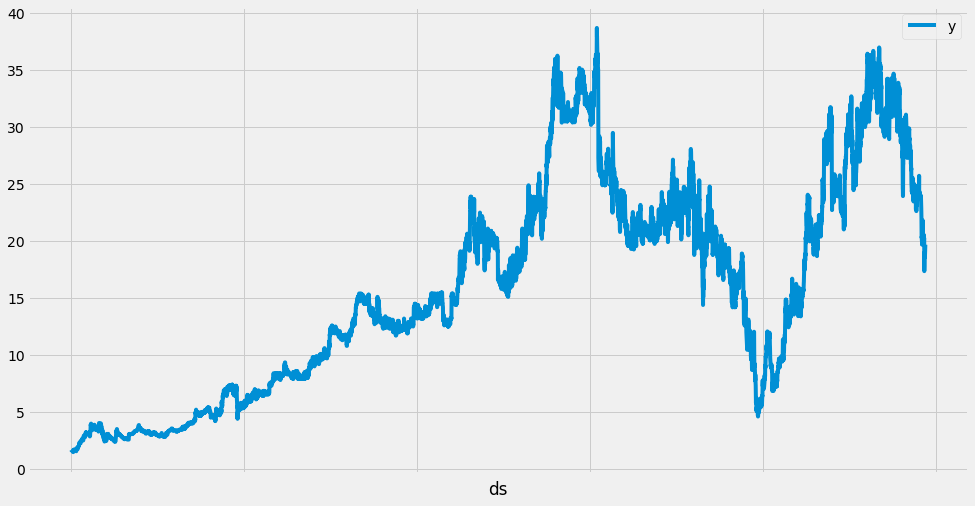

In [28]:
ax = ts.set_index('ds')
ax.plot(figsize=(15, 8))
#ax.set_ylabel('No. of Airline Passengers/Month')
#ax.set_xlabel('Date')

plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1b249710>]],
      dtype=object)

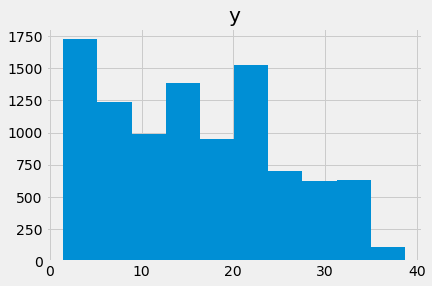

In [29]:
ts.hist()

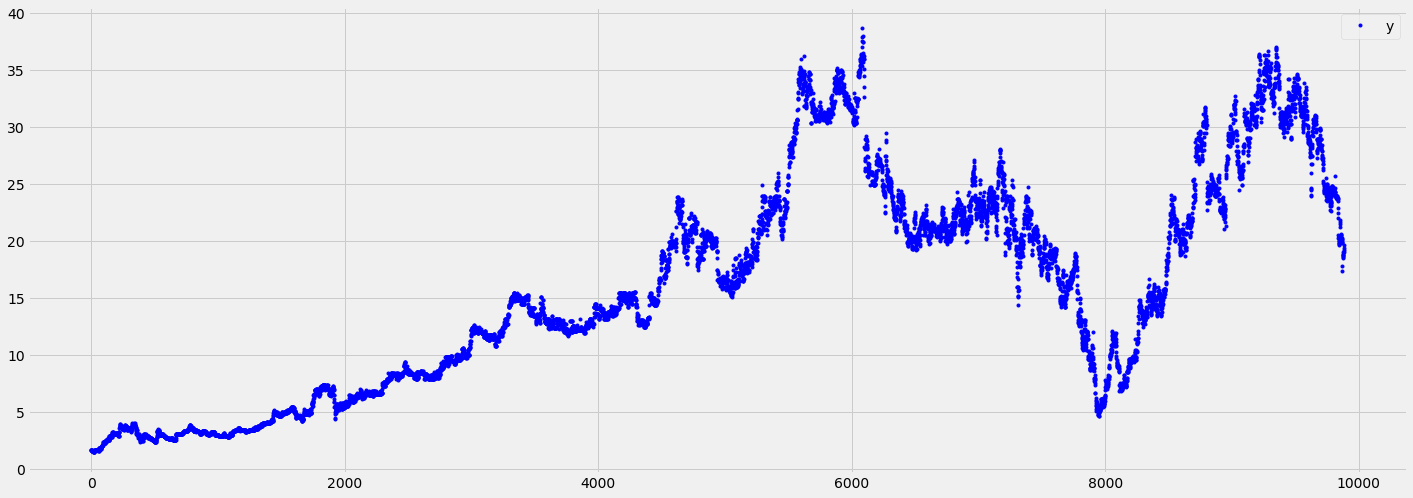

In [30]:
ts.plot(figsize = (22,8), style = 'b.')
plt.show()

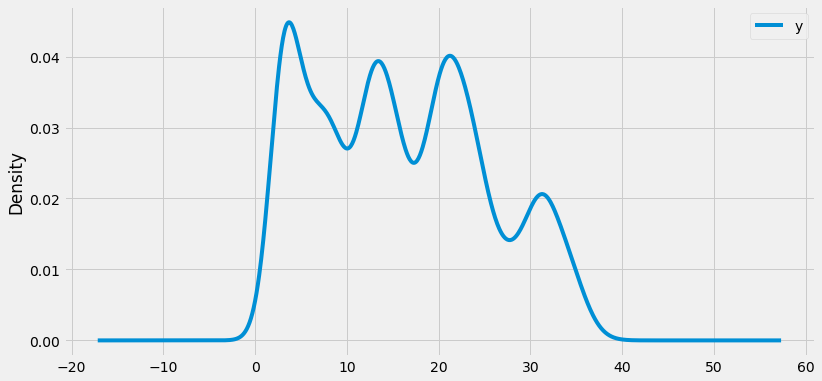

In [31]:
# Plot a density plot for coffee dataset
ts.plot(kind='kde', figsize = (12,6))
plt.show()

In [32]:
rolmean = ts['y'].rolling(window = 200, center = False).mean()
rolstd = ts['y'].rolling(window = 200, center = False).std()

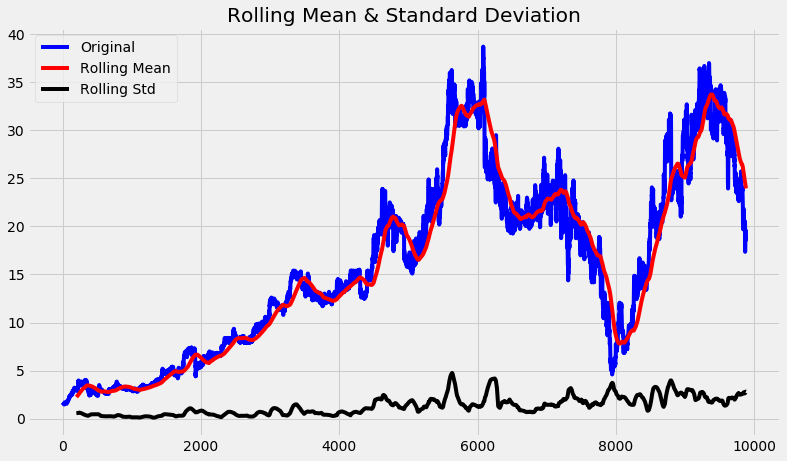

In [33]:
fig = plt.figure(figsize=(12,7))
orig = plt.plot(ts['y'], color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

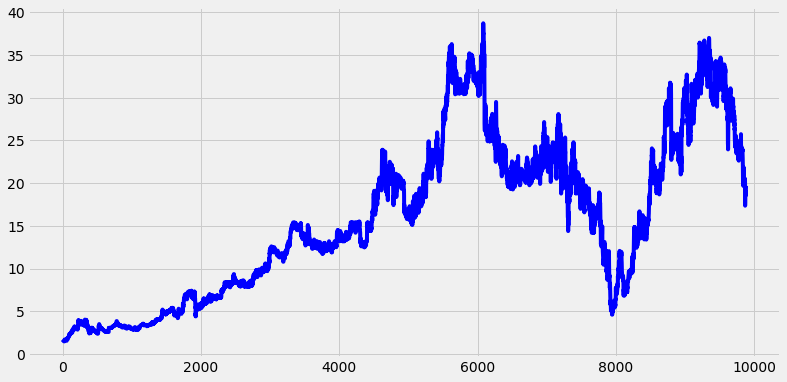

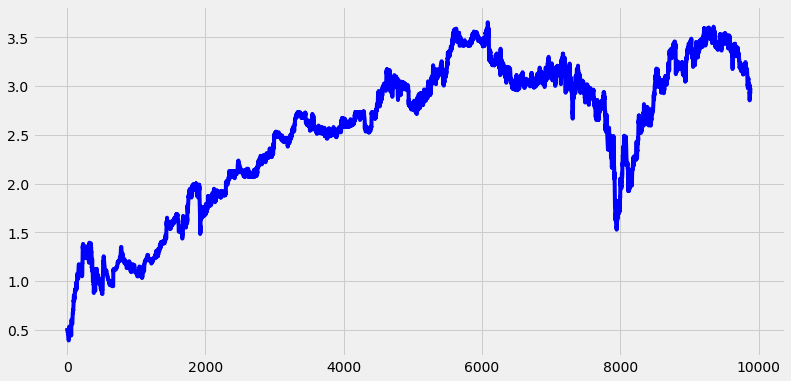

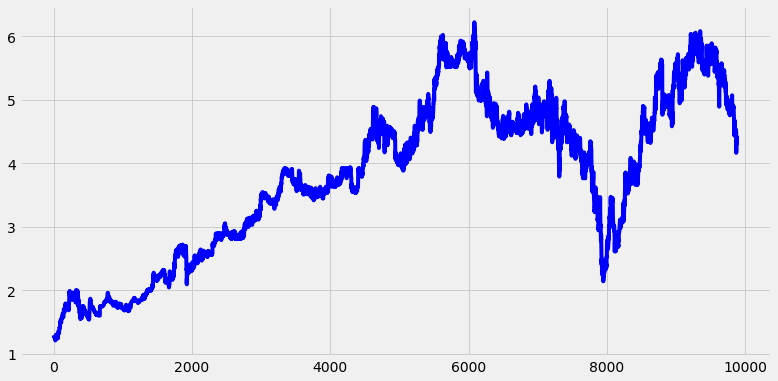

In [37]:
# Log transform timeseries and compare with original to check the effect
# Log transform timeseries and compare with original to check the effect
ts_log = np.log(ts['y'])
ts_sqrt= np.sqrt(ts['y'])
fig = plt.figure(figsize=(12,6))
plt.plot(ts['y'],  color='blue');
plt.show()
fig = plt.figure(figsize=(12,6))
plt.plot(ts_log, color='blue');
plt.show()
fig = plt.figure(figsize=(12,6))
plt.plot(ts_sqrt, color='blue');

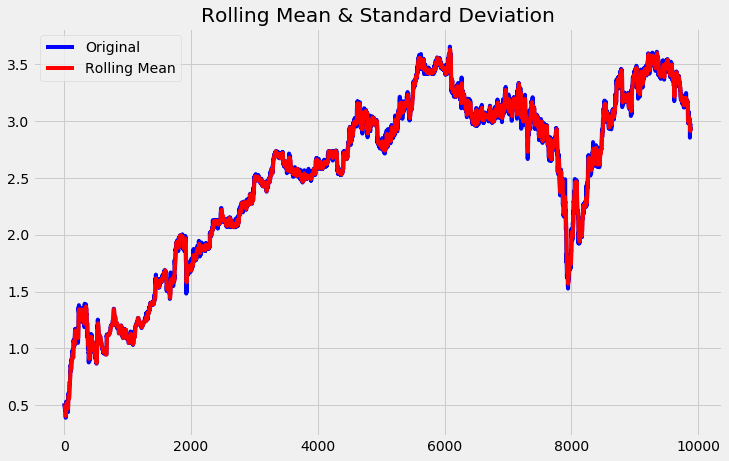

In [39]:
# your code here
rolmean = np.log(ts['y']).rolling(window = 7).mean()
fig = plt.figure(figsize=(11,7))
orig = plt.plot(np.log(ts['y']), color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [40]:
# Subtract the moving average from the original data and check
data_minus_rolmean = np.log(ts['y']) - rolmean
data_minus_rolmean.head(10)


0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
5         NaN
6   -0.015235
7   -0.024195
8   -0.019799
9   -0.015403
Name: y, dtype: float64

In [41]:
# Drop the NaN values from timeseries calculated above
data_minus_rolmean.dropna(inplace=True)

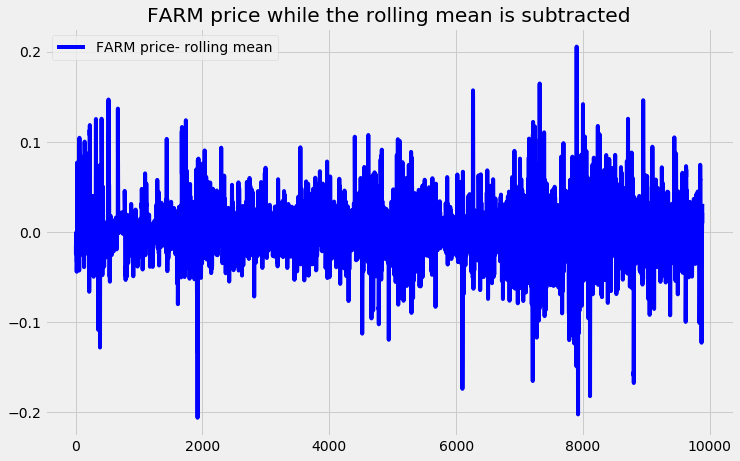

In [43]:
# Plot the result
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_rolmean, color='blue',label='FARM price- rolling mean')
plt.legend(loc='best')
plt.title('FARM price while the rolling mean is subtracted')
plt.show(block=False)

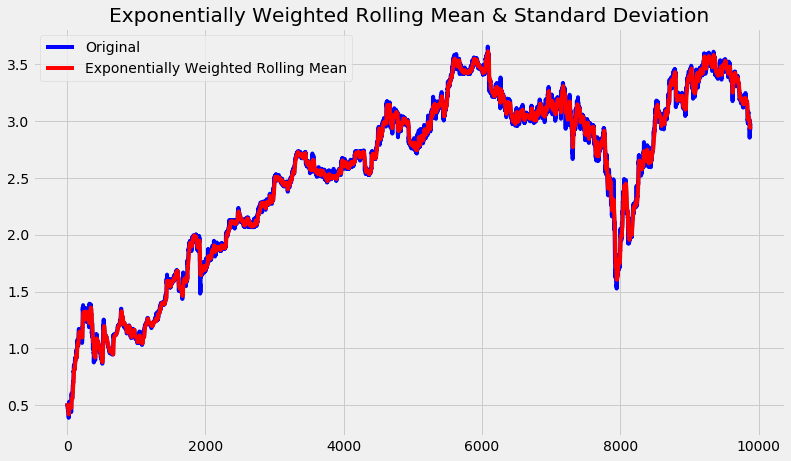

In [45]:
# Use Pandas ewma() to calculate Weighted Moving Average of ts_log

# Plot the original data with exp weighted average
# Use Pandas ewma() to calculate Weighted Moving Average of ts_log
exp_rolmean = np.log(ts['y']).ewm(halflife = 4).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(np.log(ts['y']), color='blue',label='Original')
mean = plt.plot(exp_rolmean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

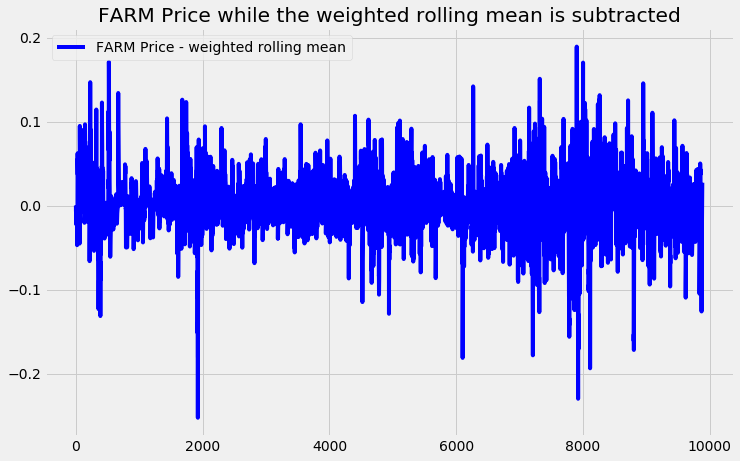

In [46]:
# Subtract the moving average from the original data and plot
# Subtract the moving average from the original data and check head for Nans
data_minus_exp_rolmean = np.log(ts['y']) - exp_rolmean
data_minus_exp_rolmean.head(15)

fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_rolmean, color='blue',label='FARM Price - weighted rolling mean')
plt.legend(loc='best')
plt.title('FARM Price while the weighted rolling mean is subtracted')
plt.show(block=False)

In [47]:
# difference your data and look at the head
data_diff = data_minus_exp_rolmean.diff(periods=12)
data_diff.head(15)

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12   -0.007917
13    0.000334
14   -0.001239
Name: y, dtype: float64

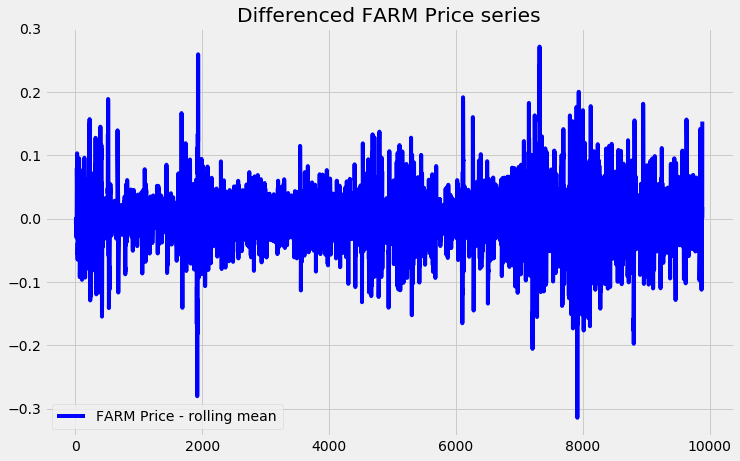

In [48]:
# plot your differenced time series
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='FARM Price - rolling mean')
plt.legend(loc='best')
plt.title('Differenced FARM Price series')
plt.show(block=False)

In [52]:
# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(ts['y']))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(ts['y']), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

AttributeError: 'Int64Index' object has no attribute 'inferred_freq'

In [68]:
ts

,ds,y
0,1980-03-17,1.675000
1,1980-03-18,1.650000
2,1980-03-19,1.650000
3,1980-03-20,1.650000
4,1980-03-21,1.650000
5,1980-03-24,1.650000
6,1980-03-25,1.625000
7,1980-03-26,1.600000
8,1980-03-27,1.600000
9,1980-03-28,1.600000


In [49]:
# drop nas
data_diff.dropna(inplace=True)

In [66]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [72]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts['y'],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =85673.413408128
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =72869.06413236403
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =31139.57960976813
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =30978.23681652835
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =31139.054898562237
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =31003.673084249323
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =30994.422365616225
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =30952.596649722167
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =72332.80004924329
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =59956.52560063966
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =23750.873912346804
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =23189.05173702302
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =23747.930472189986
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =23206.47983603592
ARIMA (0, 0, 1) 

In [73]:
# Find the parameters with minimal AIC value.

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 0, 1, 12)
aic           10987.8
Name: 57, dtype: object

In [75]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts['y'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6336      0.026     24.844      0.000       0.584       0.684
ma.L1         -0.7316      0.023    -32.275      0.000      -0.776      -0.687
ar.S.L12       0.0186      0.007      2.594      0.009       0.005       0.033
ma.S.L12      -1.0000      0.474     -2.110      0.035      -1.929      -0.071
sigma2         0.1783      0.085      2.104      0.035       0.012       0.344


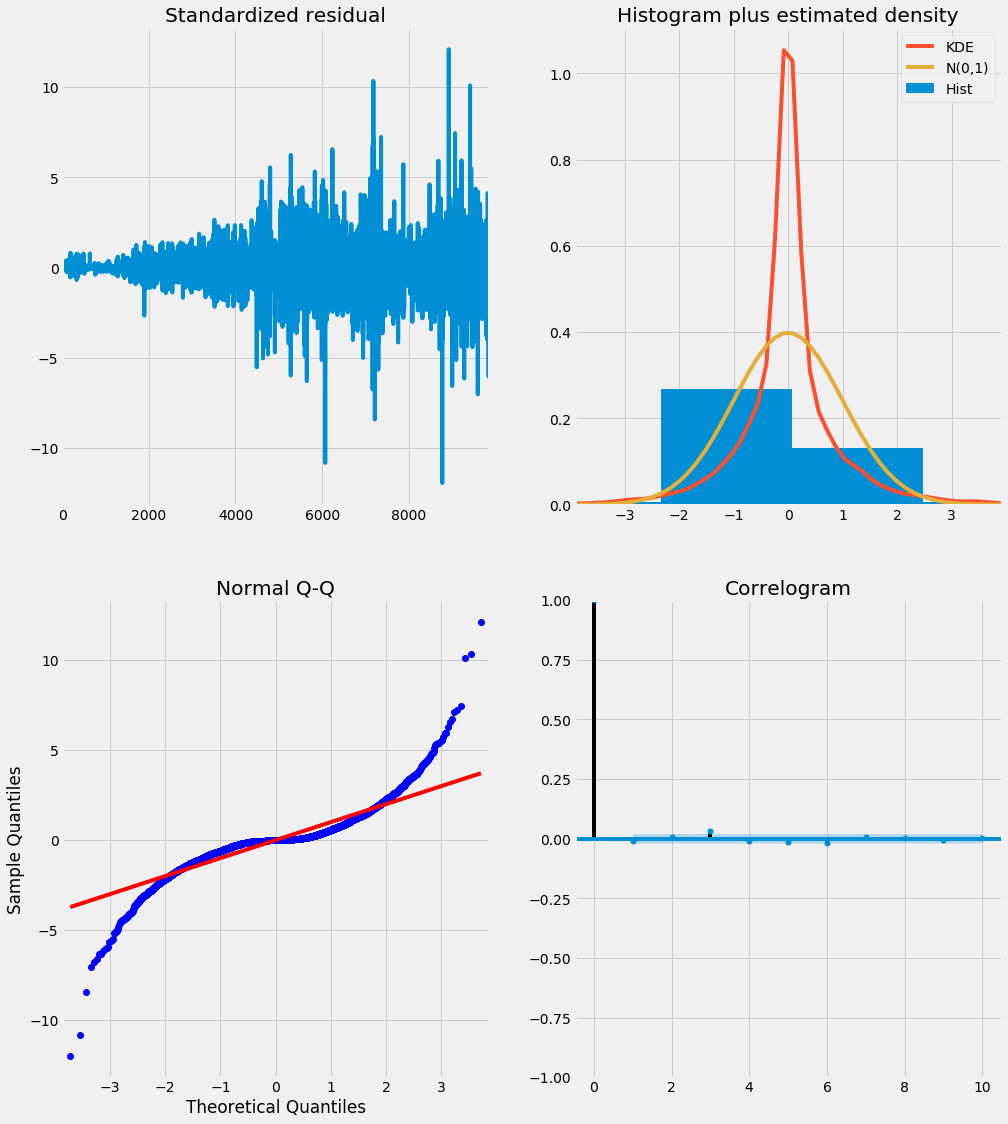

In [76]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [83]:
pred = output.get_prediction( dynamic=False)
pred_conf = pred.conf_int()

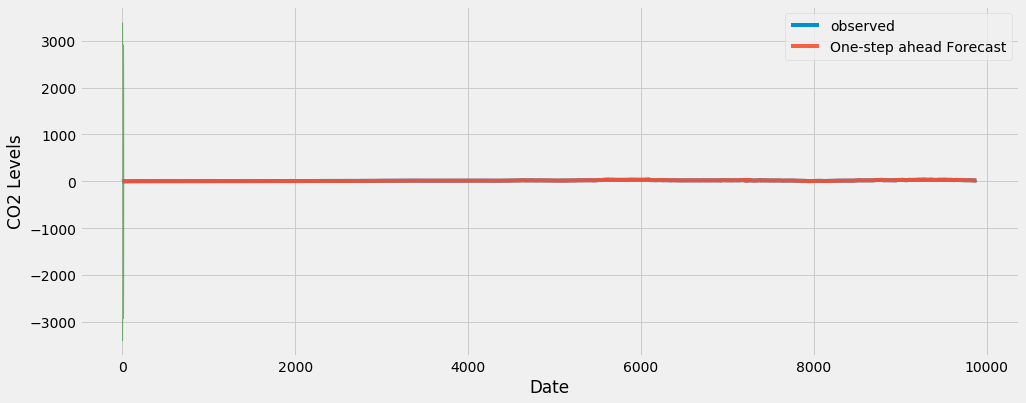

In [96]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = ts['y'].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [92]:
# Get the Real and predicted values
ts_forecasted = pred.predicted_mean
ts_truth = ts['y']

# Compute the mean square error
mse = ((ts_forecasted - ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.18


In [64]:
Model = proph(interval_width=0.95)

In [ ]:
Model.fit(ts)

In [ ]:
future_dates=Model.make_future_dataframe( periods=360)

In [ ]:
forecast = Model.predict(future_dates)
forecast.head()

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
Model.plot(forecast, uncertainty=True)
plt.show()

In [ ]:
Model.plot_components(forecast)
plt.show()

In [ ]:
difference=ts['y'].diff(periods=1)

In [ ]:
difference.plot()

In [ ]:
shifted=ts.shift(periods=50)

In [ ]:
lag_1=pd.concat([shifted,ts],axis=1)

In [ ]:
lag_1.plot(alpha=.8)

In [ ]:
lag_1.corr()

In [ ]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(ts['y'].dropna());

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_pacf(ts['y'].dropna(), lags = 100);

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
plot_acf(ts['y'],lags=10)

In [ ]:
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

# Fit an MA(1) model to the first simulated data
mod_arma = ARMA(ts['y'], order=(1,0))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

# Print out the estimate for the constant and for theta
print(res_arma.params)

In [ ]:
rolmean = ts['y'].rolling(window = 8, center = False).mean()
rolstd = ts['y'].rolling(window = 8, center = False).std()

In [ ]:
fig = plt.figure(figsize=(12,7))
orig = plt.plot(ts['y'], color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)